# Определение авторства статьи на основе нейронных сетей
### Постановка задачи:
* ......
* ......

**Распоковка датасета**

In [1]:
!unzip -u dataset.zip
print('Success')

Archive:  dataset.zip
Success


In [2]:
!zip -r datasetCSV.zip datasetHabrahabr.csv

  adding: datasetHabrahabr.csv (deflated 76%)


**Импорт пакетов**

In [3]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, SpatialDropout1D
import numpy as np
import pandas as pd
import codecs
import os

%matplotlib inline

Using TensorFlow backend.


**Загрузка готового набора данных**

In [4]:
data = pd.read_csv('datasetHabrahabr.csv')

**Загрузка тестовых документов**

In [3]:
#path = 'D:\Разработка\DataScience\Habrahabr'
path = 'Habrahabr/'
files = os.listdir(path)
data_frame = pd.DataFrame()

for file_name in files:
    file_obj = codecs.open(path + file_name, "r", "utf_8_sig" )
    file_temp = file_obj.read()
    url = file_temp[file_temp.find('url:') + 5:file_temp.find('title:')].rstrip()
    title = file_temp[file_temp.find('title:') + 7:file_temp.find('text:')].rstrip()
    text = file_temp[file_temp.find('text:') + 5:file_temp.find('author:')].rstrip()
    author = file_temp[file_temp.find('author:') + 8:].rstrip()
    row = pd.Series([url, title, text, author], index=['Url', 'Title', 'Text', 'Author'])
    data_frame = data_frame.append(row, ignore_index=True)
    file_obj.close()

**Подсчет количества слов в каждой статье**

In [14]:
data_frame['CountWords'] = data_frame['Text'].map(lambda x: len(x.split()))
print('Количество статей в корпусе:', len(data_frame))
data_frame.head()

Количество статей в корпусе: 4335


,Author,Text,Title,Url,CountWords
0,@tangro,Многие языки программирования включают в себя...,"Чем меньше, тем лучше — о возможностях языков ...",https://habrahabr.ru/company/infopulse/blog/30...,2368
1,@saul,"В шестой части серии учебных материалов, посв...","Расширения Intel Software Guard Extensions, уч...",https://habrahabr.ru/company/intel/blog/323626/,2260
2,@Andrey2008,Подобная статья уже публиковалась на нашем са...,"Open-source проекты, которые мы проверили с по...",https://habrahabr.ru/company/pvs-studio/blog/2...,496
3,@vasyay,Недавно от коллег из Callbackhunter мне попал...,Проверка устойчивости бизнес-модели с помощью ...,https://habrahabr.ru/company/twins/blog/289004/,945
4,@alexzfort,Предлагаем вашему вниманию подборку с ссылкам...,Дайджест интересных материалов из мира веб-раз...,https://habrahabr.ru/company/zfort/blog/248177/,1060


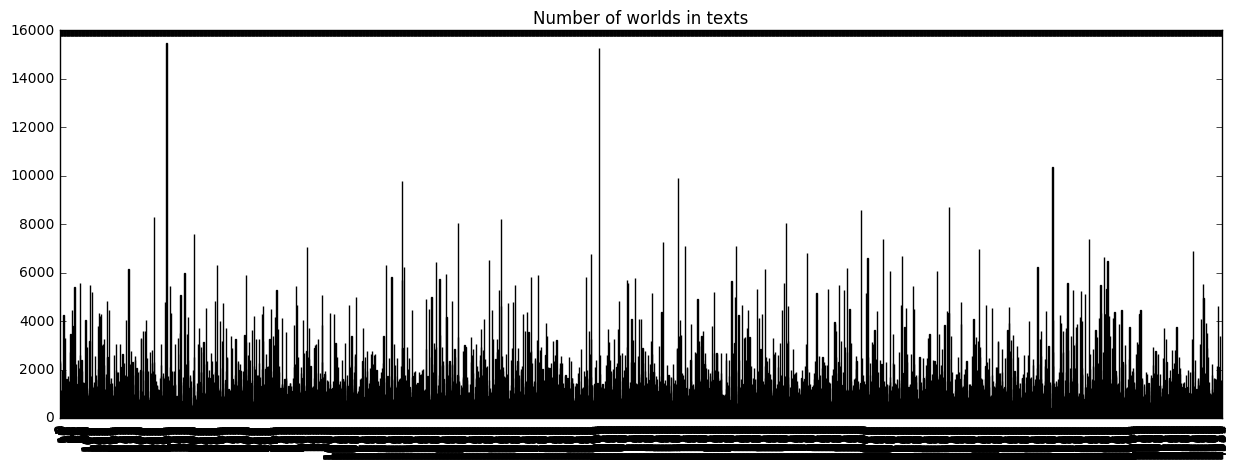

In [5]:
data_frame.CountWords.plot(kind='bar', figsize=(15, 5), title="Number of worlds in texts")

**Количество статей у каждого пользователя**

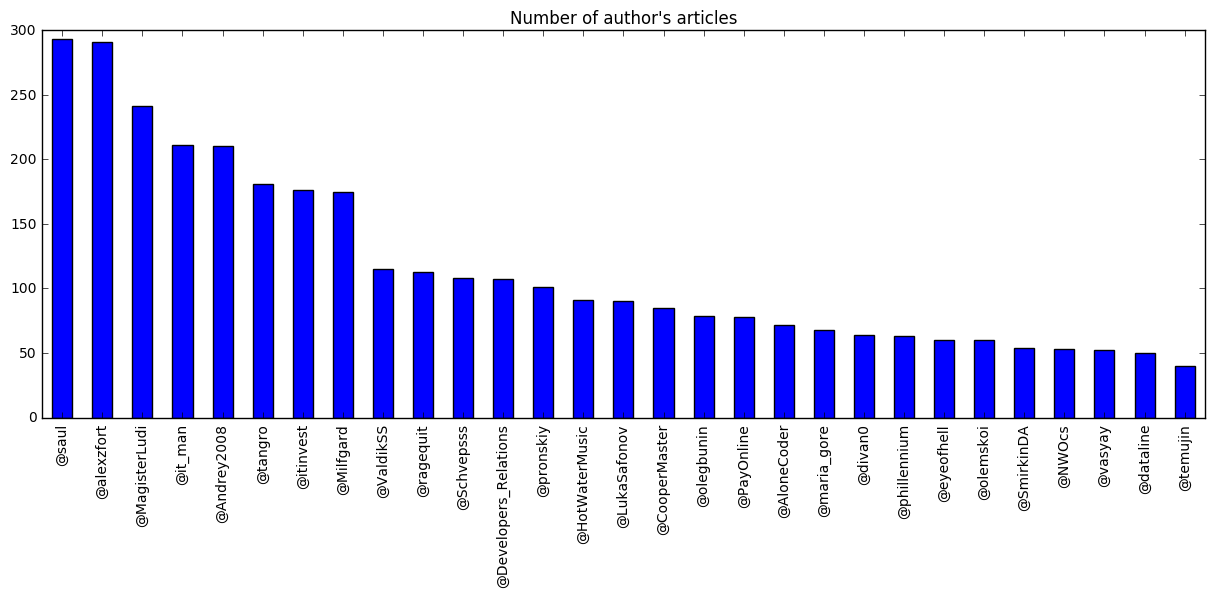

In [6]:
author_count_news = data_frame.Author.value_counts()[1:30]
author_count_news.plot(kind='bar', figsize=(15, 5), title="Number of author's articles")

### Подготовка данных для анализа
- Добавление только топ 30 авторов
- Удаление стоп слов
- Лемматизация текста
- Удаление лишних столбцов
- One hot encoding для авторов

In [15]:
data = pd.DataFrame()
names_author = author_count_news.index.values

for author in names_author:
    data = data.append(data_frame[data_frame.Author == author])

print('Количество статей после удаления:', len(data))

Количество статей после удаления: 3381


In [20]:
from nltk.corpus import stopwords
stop = stopwords.words('russian')
data['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
print('Stop words have been deleted')

Stop words have been deleted


In [22]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
data['TextLem'] = data['Text'].map(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
print('The lemmatization completed')

The lemmatization completed


In [11]:
oneHotEnc = OneHotEncoder()
lableEnc = LabelEncoder()

names = data.Author.value_counts().index.values
lableEnc.fit(names.ravel()) 
lables = lableEnc.transform(names).reshape((29, 1))
oneHotEnc.fit(lables)

#lableEnc.fit(names_author.ravel()) 
#lables = lableEnc.transform(names_author).reshape((29, 1))
#oneHotEnc.fit(lables)

# Example encoding
#aaa = lableEnc.transform(['@saul'])
#vvv = oneHotEnc.transform(aaa).toarray()
#print(vvv)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [24]:
for author in names_author:
    val = lableEnc.transform([author])[0]
    data.Author.replace(to_replace=author, value=val, inplace=True)

data = data.drop(['Url', 'Title', 'CountWords'], axis=1)
data.head()

,Author,Text,TextLem
1,25,"В шестой части серии учебных материалов, посв...","в шесть часть серия учебный материалов, посвят..."
23,25,С каждым новом поколением процессоры Intel вб...,с каждый новый поколение процессор intel вбира...
25,25,Статья в блоге Intel «Прокачай свой жесткий д...,статья в блог intel «прокачать свой жёсткий ди...
27,25,Испанская компания с говорящим названием Geek...,испанский компания с говорящий название geeksp...
32,25,igzip — высокопроизводительная библиотека для...,igzip — высокопроизводительный библиотека для ...


**Сохранение датасета**

In [28]:
filename = 'datasetHabrahabr.csv'
data.to_csv(filename, index=False, encoding='utf-8')

### Производим векторизацию текста с помощью TF-IDF

In [6]:
texts = data['Text']
textsLem = data['TextLem']
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r'
max_features = 50000

In [25]:
tokenizer = Tokenizer(filters=filters, split=" ", lower=True)
tokenizer.fit_on_texts(texts)
matrix_tfidf = tokenizer.texts_to_matrix(texts=texts, mode='tfidf')

print('Количество текстов:', matrix_tfidf.shape[0])
print('Количество токенов без лемматизации:', matrix_tfidf.shape[1])

Количество текстов: 3381
Количество токенов без лемматизации: 254167


In [26]:
tokenizer = Tokenizer(filters=filters, split=" ", lower=True)
tokenizer.fit_on_texts(textsLem)
matrix_tfidf_lem = tokenizer.texts_to_matrix(texts=textsLem, mode='tfidf')

print('Количество текстов:', matrix_tfidf_lem.shape[0])
print('Количество токенов c лемматизацией:', matrix_tfidf_lem.shape[1])

Количество текстов: 3381
Количество токенов c лемматизацией: 199336


In [7]:
tokenizer = Tokenizer(filters=filters, split=" ", lower=True, num_words=max_features)
tokenizer.fit_on_texts(data['TextLem'])
matrix_tfidf = tokenizer.texts_to_matrix(texts=data['TextLem'], mode='tfidf')

print('Количество текстов ' + str(matrix_tfidf.shape[0]))
print('Количество токенов ' + str(matrix_tfidf.shape[1]))

Количество текстов 3381
Количество токенов 50000


### Разбиваем выборку на тестовую и тренировочную

In [12]:
X = matrix_tfidf
#X = matrix_tfidf_lem
y = oneHotEnc.transform(data.Author.values.reshape(-1, 1)).toarray()

### Создание модели нейронной сети

In [13]:
model = Sequential()
# Слой для векторного представления слов
model.add(Embedding(max_features, 32))
model.add(SpatialDropout1D(0.2))
# Слой долго-краткосрочной памяти
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
# Полносвязный слой
model.add(Dense(29, activation="sigmoid"))
# Копмилируем модель
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#SGD
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X, y, batch_size=15, epochs=2, shuffle=True, validation_split=0.2)
#model.fit(X, y, batch_size=64, epochs=3, verbose=2, shuffle=True, validation_split=0.2)
# Проверяем качество обучения на тестовых данных
#scores = model.evaluate(X, y, batch_size=1000)
#print("Точность на тестовых данных: %.2f%%" % (scores[1] * 100))

Train on 2704 samples, validate on 677 samples
Epoch 1/2
2704/2704 [==============================] - 12860s - loss: 2.8740 - acc: 0.1032 - val_loss: 8.2748 - val_acc: 0.0000e+00

In [ ]:
model.evaluate(X, y, batch_size=64)[1] * 100

In [ ]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("model/habra_model_2.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("model/habra_model_weights_2.h5")